In [338]:
#from call_functions import *
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
import plotly.express as px
import ipywidgets as widgets

In [339]:
def func(x,w,d):
    return w**2 - x*9.81*np.tanh(x*d)

def k_from_w(w,d):
    return fsolve(func,w**2/9.81,args=(w,d))

In [340]:
g = 9.81 #(en m/s^2)
d = 1000 #(en metres)
T_p = 10 #(periode de pic)
h_s = 3  #(hauteur significative en m)

f_p = 1/T_p #(frequence de pic)
w_p = 2*np.pi*f_p #(frequence angulaire de pic)
k_p = k_from_w(w_p,d) #(nombre d'onde de pic)
l_p = np.pi*2/k_p #(longueur d'onde de pic)

L = l_p * 64 #(en metres)
Nx = (64 * 32) #//4 #(au moins 32 points par longeur d'onde de pic)
dx = L/(Nx)

xspace = np.linspace(0,L-dx,Nx)
#xspace = xspace[:-1]

#k_n = np.arange(-Nx/2,Nx/2)*2*np.pi/L

k_n = 2*np.pi*np.fft.fftfreq(Nx,dx)
w_n = np.sqrt(g*np.abs(k_n)*np.tanh(d*np.abs(k_n)))

In [341]:
# calcul de dw/dk

dw_n_dk_n = np.zeros(len(w_n))
dw_n_dk_n2 = np.zeros(len(w_n))
dw_n_dk_n[k_n!=0] = np.abs( (1/2)*(w_n[k_n!=0]/k_n[k_n!=0])*(1 + 2*k_n[k_n!=0]*d / np.sinh(2*k_n[k_n!=0]*d)))
dw_n_dk_n2[k_n!=0] = np.abs(g * (np.tanh(d*k_n[k_n!=0]) + d * k_n[k_n!=0] *(1/np.cosh(d *k_n[k_n!=0]))**2)/(2 * np.sqrt(g * k_n[k_n!=0] * np.tanh(d * k_n[k_n!=0]))))

/var/folders/vb/z01wks0d25n399v1c2rv_r6000mb9z/T/ipykernel_57233/1434424902.py:5: RuntimeWarning:

overflow encountered in sinh



In [342]:
# test si dw/dk donne bien la meme chose avec les deux formulations
np.linalg.norm(dw_n_dk_n - dw_n_dk_n2)

2.916570888665544e-14

`f_p` : fréquecne de pic (de l'odre de 8 ou 10 secondes) donc `f_p = 1/8 ou 1/10`

`T_p` : période de pic donc `T_p = 8 ou 10`

In [343]:
# fonction pour calculer le spectre de jonswap (sur f)

def E(f,f_p,gamma,alpha_s):
    Ef = np.zeros(len(f))
    sigma_s = 0.07 * (f[f!=0] <= f_p) + 0.09 * (f[f!=0] > f_p)
    Ef[f!=0] = alpha_s * (9.81**2/f[f!=0]**5) * np.exp(- 5/4 * ((f_p/f[f!=0])**4)) * gamma ** np.exp(- (f[f!=0] - f_p)**2/(2*sigma_s**2*f_p**2))
    return Ef

Ef = E(w_n/(2*np.pi),w_p/(2*np.pi),3.3,1)
Ek = dw_n_dk_n * Ef * (1/(2 * np.pi))
alpha_s_new = h_s**2 /(16 * np.sum(Ek * np.abs(k_n[1] - k_n[0])))
Ek = Ek * alpha_s_new
Ef = Ef * alpha_s_new

In [344]:
np.sum(Ek * np.abs(k_n[1] - k_n[0])) - h_s**2/16

-1.1102230246251565e-16

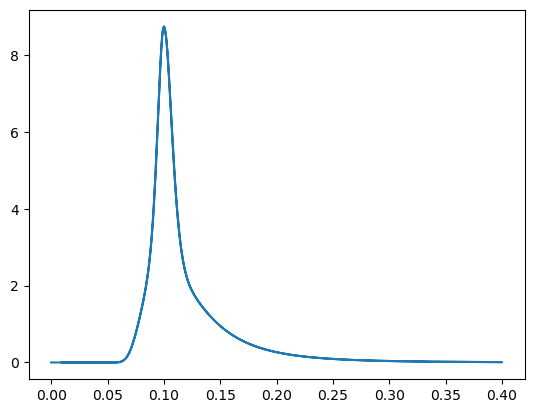

In [345]:
plt.plot(w_n/(2*np.pi),Ef)

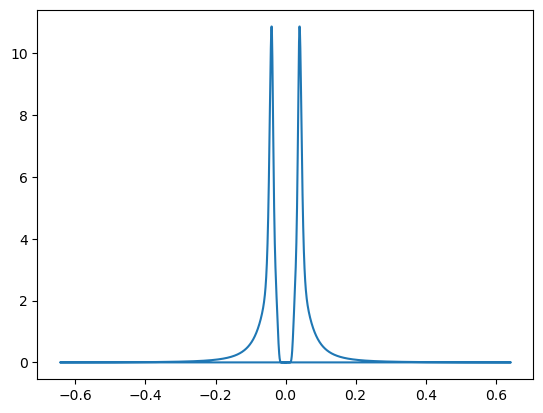

In [346]:
plt.plot(k_n,Ek)

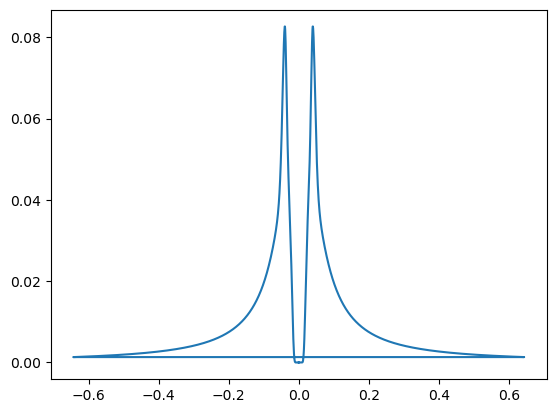

In [347]:
# EK / 2 parce que on apris deux fois le spectre (double vagues donc doubles amplitudes)

A_n = np.sqrt(2 * Ek / 2 * np.abs(k_n[1] - k_n[0]))
plt.plot(k_n,A_n)

In [348]:
t = 0
phase = np.random.rand(len(A_n)//2+1)*2*np.pi
phase = np.append(phase,np.flip(phase[(len(A_n) + 1) % 2:-1]))

A_n2 = A_n * np.exp(- 1j * (phase - w_n * t))
A_n2 = np.append(A_n2[:Nx//2].conj(),A_n2[Nx//2:])

eta = np.real(np.fft.ifft(A_n2, norm=None))*(Nx)

t = 10
A_n22 = A_n * np.exp(- 1j * (phase - w_n * t))
A_n22 = np.append(A_n22[:Nx//2].conj(),A_n22[Nx//2:])

eta2 = np.real(np.fft.ifft(A_n22, norm=None))*(Nx)

def eta_func(x,t):
    theta = np.outer(np.abs(k_n),x) - np.outer(w_n,t)
    A_n2 = A_n * np.exp(1j * (phase - w_n * t))
    return np.real(np.sum(A_n2.reshape((len(k_n),1)) * np.exp(1j * np.outer(np.abs(k_n),x)),axis=0))

def phi_func(x,t):
    theta = np.outer(np.abs(k_n),x) - np.outer(w_n,t)
    A_n2 = A_n * np.exp(1j * (phase - w_n * t))
    A_n2[w_n != 0] = A_n2[w_n != 0] * (- 1j * 9.81 / w_n[w_n != 0])
    return np.real(np.sum(A_n2.reshape((len(k_n),1)) * np.exp(1j * np.outer(np.abs(k_n),x)),axis=0))

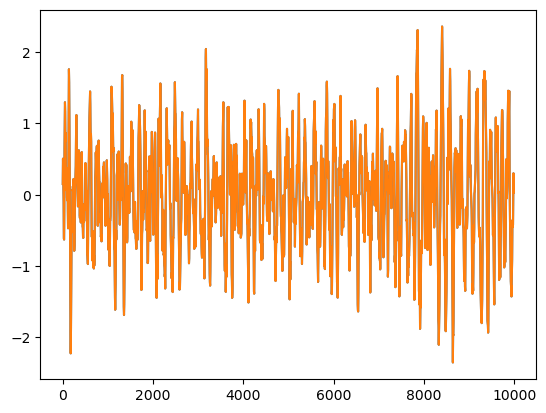

In [349]:
plt.plot(xspace,eta_func(xspace,0))
plt.plot(xspace,eta)

In [351]:
np.linalg.norm(eta - eta_func(xspace,0))

1.5578456071838798e-12

In [353]:
print(np.std(eta)**2 - h_s**2/16)

-1.6129274715837028e-06


## TEST 1

In [392]:
# Definitions des parametres (taille du domaine observe, grille)

Lx_obs = L
Nx_obs = Nx
dx_obs = Lx_obs/(Nx_obs)
xspace_obs = np.linspace(0,Lx_obs-dx_obs,Nx_obs).reshape((Nx_obs,))

In [393]:
# Definition des frequences

k_obs = 2*np.pi*np.fft.fftfreq(Nx_obs, dx_obs)

# Definition de la matrice de l'operateur G

A_dz = np.zeros((Nx_obs, Nx_obs))
kernel = np.real(np.fft.ifft(abs(k_obs), axis=0, norm=None))*Nx_obs
for ii in range(Nx_obs):
    rolled_kernel = np.roll(kernel, ii)
    A_dz[ii, :] = 1/Nx_obs*rolled_kernel

# Choix du gain de l'observateur (defaut = 1)

gain = 1

# Definition des matrices de DFT, iDFT et Projections sur l'espace des frequences sans le mode 0

def getF(Nu):
    return np.exp(-1j*2*np.pi/Nu)**np.outer(np.arange(0,Nu ,1),np.arange(0,Nu ,1))

def getiF(Nu):
    return 1/Nu * np.exp(1j*2*np.pi/Nu)**np.outer(np.arange(0,Nu ,1),np.arange(0,Nu ,1))

def P0(Nu):
    return np.dot(getiF(Nu),np.dot(np.diag(np.concatenate((np.array([0]),np.ones(Nu-1)))),getF(Nu)))

# Definition des matrices des equations

I = -9.81*np.eye(Nx_obs)
O = np.zeros((Nx_obs,Nx_obs))
Obs = np.diag(xspace_obs < Lx_obs) * 1
A = np.block([[O, I], [A_dz, O]])
M = np.block([[O, I], [A_dz, - gain * np.real(np.dot(P0(Nx_obs),Obs))]])

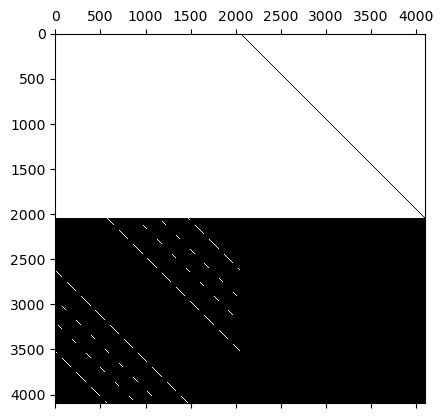

In [394]:
# Affichage de la matrice

plt.spy(M)

In [396]:
# Definition des fonctions pour le solver

def func_model(u,t):
    return np.dot(A,u)

def g(t):
    return np.concatenate((np.zeros(Nx_obs),np.dot(Obs,eta_func(xspace_obs,t))))

Proj = P0(Nx_obs)
Proj = np.block([[P0(Nx_obs), O], [O, P0(Nx_obs)]])

def func_obs(u,t):
    return np.dot(M,u) + gain * np.real(np.dot(Proj,g(t)))

In [403]:
# Definition des conditions initiales

y0 = np.concatenate((phi_func(xspace_obs,0),eta_func(xspace_obs,0)))
y0_obs = np.zeros(Nx_obs*2)

In [405]:
# SOLVER

Tend = 60
tspace = np.linspace(0,Tend,Tend+1)

sol_obs = odeint(func_obs, y0_obs, tspace)
#sol = odeint(func_model, y0, tspace)

In [406]:
# Verification des tailles des sorties, et recuperation des donnes de surface

print(sol_obs.shape)
sol_obs_surface = sol_obs[:,Nx_obs:]
sol_obs_potential = sol_obs[:,:Nx_obs]
print(sol_obs_surface.shape)
print(sol_obs_potential.shape)

(60, 4096)
(60, 2048)
(60, 2048)


In [407]:
# Recuperation de la solution exacte sur la grille et sur le domaine de l'observateur
# Verification des tailles des sorties

groundtruth = np.zeros(sol_obs.shape)
for tt in range(len(tspace)):
    groundtruth[tt,:] = np.concatenate((phi_func(xspace_obs,tspace[tt]),eta_func(xspace_obs,tspace[tt])))

print(groundtruth.shape)
groundtruth_surface = groundtruth[:,Nx_obs:]
groundtruth_potential = groundtruth[:,:Nx_obs]
print(groundtruth_surface.shape)
print(groundtruth_potential.shape)

(60, 4096)
(60, 2048)
(60, 2048)


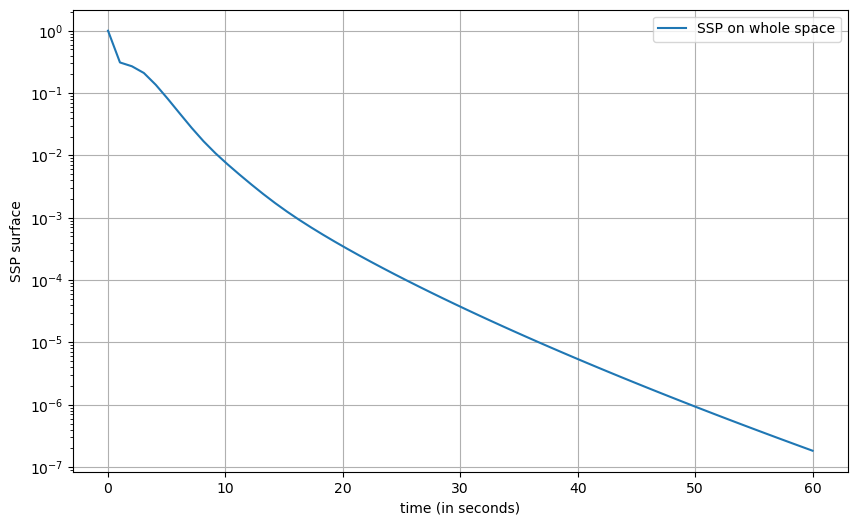

In [409]:
# Calcul, plot et sauvegarde des erreurs (SSP)

# erreur sur l'ensemble de l'intervalle
error = np.fft.fft(groundtruth_surface) - np.fft.fft(sol_obs_surface)
error_n2 = np.linalg.norm(error,2,axis=1)
groundtruth_n2 = np.linalg.norm(np.fft.fft(groundtruth_surface),2,axis=1)
sol_obs_n2 = np.linalg.norm(np.fft.fft(sol_obs_surface),2,axis=1)

SSP = error_n2 / (groundtruth_n2 + sol_obs_n2)

plt.figure(figsize=(10, 6))

plt.semilogy(tspace,SSP,label = 'SSP on whole space')

plt.ylabel(f'SSP surface')
plt.xlabel(f'time (in seconds)')
plt.grid()
plt.legend()

plt.savefig('results/test_1/t1_ssp.png')

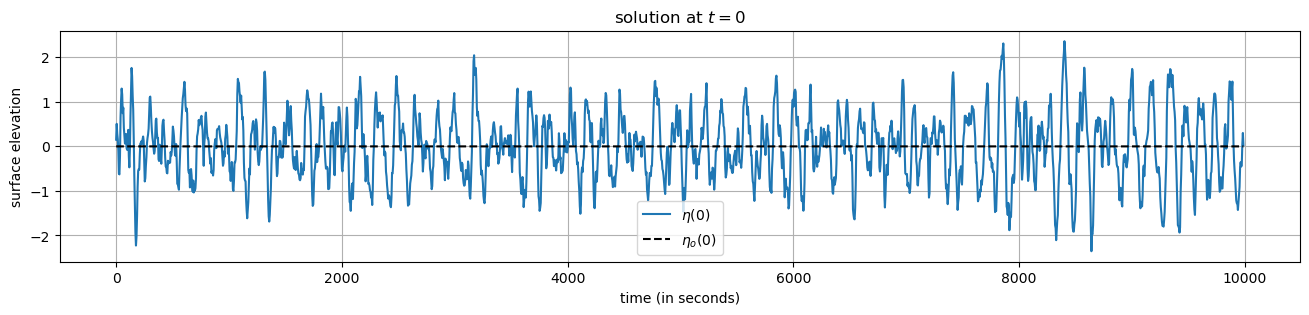

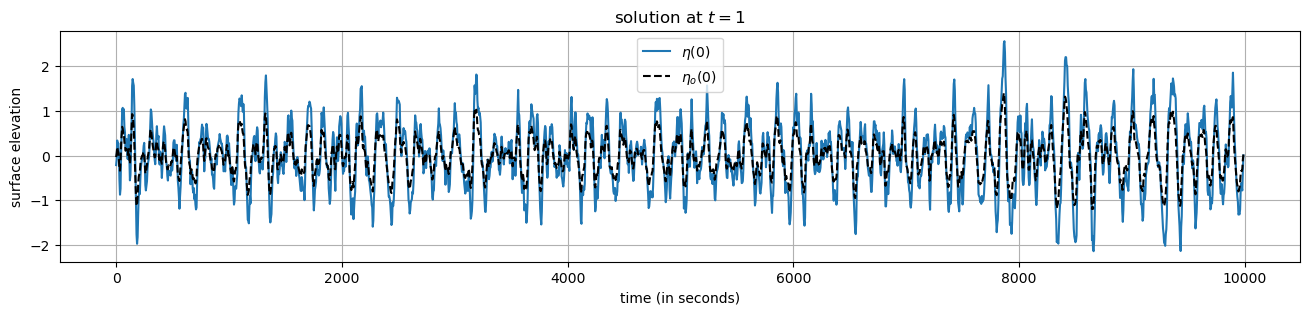

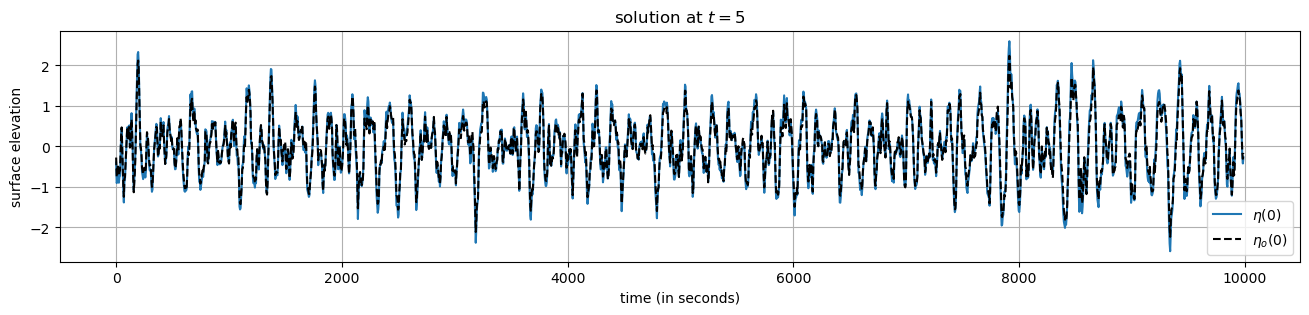

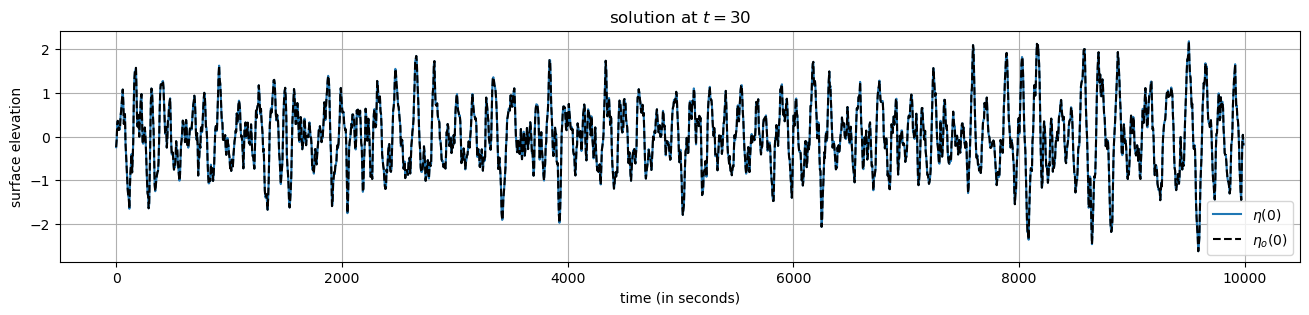

In [411]:
# plot et sauvegarde les snapshots

timeshots_wanted = [0,1,5,30]

for i,timeshot in enumerate(timeshots_wanted):
    plt.figure(figsize=(16, 3))
    plt.plot(xspace_obs,eta_func(xspace_obs,tspace[timeshot]),label=f'$\eta(0)$')
    plt.plot(xspace_obs,sol_obs[timeshot,:][Nx_obs:],'k--',label=f'$\eta_o(0)$')
    plt.xlabel('time (in seconds)')
    plt.ylabel('surface elevation')
    plt.legend()
    plt.title(f'solution at $t = {timeshot}$')
    plt.grid()

    plt.savefig(f'results/test_1/t1_snapshot_t{str(timeshot)}')

## TEST 2

In [412]:
# Definitions des parametres (taille du domaine observe, grille)

Lx_obs = L
Nx_obs = Nx
dx_obs = Lx_obs/(Nx_obs)
xspace_obs = np.linspace(0,Lx_obs-dx_obs,Nx_obs).reshape((Nx_obs,))

In [413]:
# Definition des frequences

k_obs = 2*np.pi*np.fft.fftfreq(Nx_obs, dx_obs)

# Definition de la matrice de l'operateur G

A_dz = np.zeros((Nx_obs, Nx_obs))
kernel = np.real(np.fft.ifft(abs(k_obs), axis=0, norm=None))*Nx_obs
for ii in range(Nx_obs):
    rolled_kernel = np.roll(kernel, ii)
    A_dz[ii, :] = 1/Nx_obs*rolled_kernel

# Choix du gain de l'observateur (defaut = 1)

gain = 1

# Definition des matrices de DFT, iDFT et Projections sur l'espace des frequences sans le mode 0

def getF(Nu):
    return np.exp(-1j*2*np.pi/Nu)**np.outer(np.arange(0,Nu ,1),np.arange(0,Nu ,1))

def getiF(Nu):
    return 1/Nu * np.exp(1j*2*np.pi/Nu)**np.outer(np.arange(0,Nu ,1),np.arange(0,Nu ,1))

def P0(Nu):
    return np.dot(getiF(Nu),np.dot(np.diag(np.concatenate((np.array([0]),np.ones(Nu-1)))),getF(Nu)))

# Definition des matrices des equations

I = -9.81*np.eye(Nx_obs)
O = np.zeros((Nx_obs,Nx_obs))
Obs = np.diag(xspace_obs < Lx_obs // 2) * 1
A = np.block([[O, I], [A_dz, O]])
M = np.block([[O, I], [A_dz, - gain * np.real(np.dot(P0(Nx_obs),Obs))]])

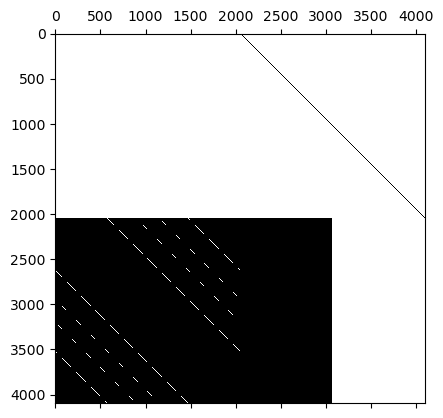

In [414]:
# Affichage de la matrice

plt.spy(M)

In [415]:
# Definition des fonctions pour le solver

def func_model(u,t):
    return np.dot(A,u)

def g(t):
    return np.concatenate((np.zeros(Nx_obs),np.dot(Obs,eta_func(xspace_obs,t))))

Proj = P0(Nx_obs)
Proj = np.block([[P0(Nx_obs), O], [O, P0(Nx_obs)]])

def func_obs(u,t):
    return np.dot(M,u) + gain * np.real(np.dot(Proj,g(t)))

In [416]:
# Definition des conditions initiales

y0 = np.concatenate((phi_func(xspace_obs,0),eta_func(xspace_obs,0)))
y0_obs = np.zeros(Nx_obs*2)

In [417]:
# SOLVER

Tend = 60
tspace = np.linspace(0,Tend,Tend+1)

sol_obs = odeint(func_obs, y0_obs, tspace)
#sol = odeint(func_model, y0, tspace)

In [ ]:
# Verification des tailles des sorties, et recuperation des donnes de surface

print(sol_obs.shape)
sol_obs_surface = sol_obs[:,Nx_obs:]
sol_obs_potential = sol_obs[:,:Nx_obs]
print(sol_obs_surface.shape)
print(sol_obs_potential.shape)

In [ ]:
# Recuperation de la solution exacte sur la grille et sur le domaine de l'observateur
# Verification des tailles des sorties

groundtruth = np.zeros(sol_obs.shape)
for tt in range(len(tspace)):
    groundtruth[tt,:] = np.concatenate((phi_func(xspace_obs,tspace[tt]),eta_func(xspace_obs,tspace[tt])))

print(groundtruth.shape)
groundtruth_surface = groundtruth[:,Nx_obs:]
groundtruth_potential = groundtruth[:,:Nx_obs]
print(groundtruth_surface.shape)
print(groundtruth_potential.shape)

In [ ]:
# Calcul, plot et sauvegarde des erreurs (SSP)

# erreur sur l'ensemble de l'intervalle
error = np.fft.fft(groundtruth_surface) - np.fft.fft(sol_obs_surface)
error_n2 = np.linalg.norm(error,2,axis=1)
groundtruth_n2 = np.linalg.norm(np.fft.fft(groundtruth_surface),2,axis=1)
sol_obs_n2 = np.linalg.norm(np.fft.fft(sol_obs_surface),2,axis=1)

SSP = error_n2 / (groundtruth_n2 + sol_obs_n2)

plt.figure(figsize=(10, 6))

plt.semilogy(tspace,SSP,label = 'SSP on whole space')

plt.ylabel(f'SSP surface')
plt.xlabel(f'time (in seconds)')
plt.grid()
plt.legend()

#plt.savefig('results/test_2/t2_ssp.png')

In [ ]:
# plot et sauvegarde les snapshots

timeshots_wanted = [0,1,5,30]

for i,timeshot in enumerate(timeshots_wanted):
    plt.figure(figsize=(16, 3))
    plt.plot(xspace_obs,eta_func(xspace_obs,tspace[timeshot]),label=f'$\eta(0)$')
    plt.plot(xspace_obs,sol_obs[timeshot,:][Nx_obs:],'k--',label=f'$\eta_o(0)$')
    plt.xlabel('time (in seconds)')
    plt.ylabel('surface elevation')
    plt.legend()
    plt.title(f'solution at $t = {timeshot}$')
    plt.grid()

    #plt.savefig(f'results/test_2/t2_snapshot_t{str(timeshot)}')

## TEST 3

## TEST 4

In [354]:
# Definitions des parametres (taille du domaine observe, grille)

Lx_obs = 8*l_p*2
Nx_obs = 128*2+1
dx_obs = Lx_obs/(Nx_obs)
xspace_obs = np.linspace(0,Lx_obs-dx_obs,Nx_obs).reshape((Nx_obs,))

In [355]:
# Definition des frequences

k_obs = 2*np.pi*np.fft.fftfreq(Nx_obs, dx_obs)

# Definition de la matrice de l'operateur G

A_dz = np.zeros((Nx_obs, Nx_obs))
kernel = np.real(np.fft.ifft(abs(k_obs), axis=0, norm=None))*Nx_obs
for ii in range(Nx_obs):
    rolled_kernel = np.roll(kernel, ii)
    A_dz[ii, :] = 1/Nx_obs*rolled_kernel

# Choix du gain de l'observateur (defaut = 1)

gain = 1

# Definition des matrices de DFT, iDFT et Projections sur l'espace des frequences sans le mode 0

def getF(Nu):
    return np.exp(-1j*2*np.pi/Nu)**np.outer(np.arange(0,Nu ,1),np.arange(0,Nu ,1))

def getiF(Nu):
    return 1/Nu * np.exp(1j*2*np.pi/Nu)**np.outer(np.arange(0,Nu ,1),np.arange(0,Nu ,1))

def P0(Nu):
    return np.dot(getiF(Nu),np.dot(np.diag(np.concatenate((np.array([0]),np.ones(Nu-1)))),getF(Nu)))

I = -9.81*np.eye(Nx_obs)
O = np.zeros((Nx_obs,Nx_obs))
Obs = np.diag(xspace_obs < Lx_obs//2) * 1
A = np.block([[O, I], [A_dz, O]])
M = np.block([[O, I], [A_dz, - gain * np.real(np.dot(P0(Nx_obs),Obs))]])

In [375]:
# Affichage de la matrice

#plt.spy(M)

In [357]:
# Definition des fonctions pour le solver

def func_model(u,t):
    return np.dot(A,u)

def g(t):
    return np.concatenate((np.zeros(Nx_obs),np.dot(Obs,eta_func(xspace_obs,t))))

Proj = P0(Nx_obs)
Proj = np.block([[P0(Nx_obs), O], [O, P0(Nx_obs)]])

def func_obs(u,t):
    return np.dot(M,u) + gain * np.real(np.dot(Proj,g(t)))

In [376]:
# T = 0

# plt.plot(np.concatenate((phi_func(xspace_obs,T),eta_func(xspace_obs,T))))
# plt.plot(g(T))

In [377]:
# Definition des conditions initiales

y0 = np.concatenate((phi_func(xspace_obs,0),eta_func(xspace_obs,0)))
y0_obs = np.zeros(Nx_obs*2)
y0_obs = g(0)

# plt.plot(y0)
# plt.plot(y0_obs)

In [361]:
# SOLVER

Tend = 60*30
tspace = np.linspace(0,Tend,Tend)

sol_obs = odeint(func_obs, y0_obs, tspace)
#sol = odeint(func_model, y0, tspace)

In [362]:
# Verification des tailles des sorties, et recuperation des donnes de surface

print(sol_obs.shape)
sol_obs_surface = sol_obs[:,Nx_obs:]
sol_obs_potential = sol_obs[:,:Nx_obs]
print(sol_obs_surface.shape)
print(sol_obs_potential.shape)

(1800, 514)
(1800, 257)
(1800, 257)


In [363]:
# Recuperation de la solution exacte sur la grille et sur le domaine de l'observateur
# Verification des tailles des sorties

groundtruth = np.zeros(sol_obs.shape)
for tt in range(len(tspace)):
    groundtruth[tt,:] = np.concatenate((phi_func(xspace_obs,tspace[tt]),eta_func(xspace_obs,tspace[tt])))

print(groundtruth.shape)
groundtruth_surface = groundtruth[:,Nx_obs:]
groundtruth_potential = groundtruth[:,:Nx_obs]
print(groundtruth_surface.shape)
print(groundtruth_potential.shape)

(1800, 514)
(1800, 257)
(1800, 257)


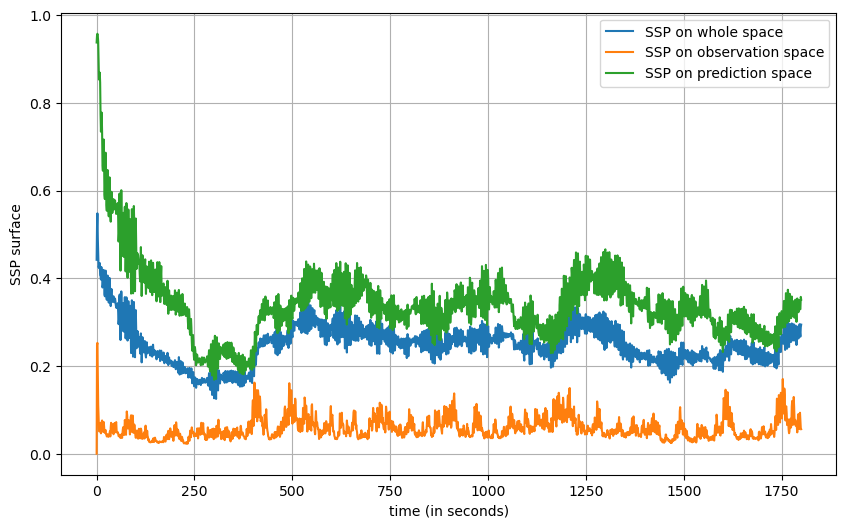

In [378]:
# Calcul et plot des erreurs (SSP)

# erreur sur l'ensemble de l'intervalle
error = np.fft.fft(groundtruth_surface) - np.fft.fft(sol_obs_surface)
error_n2 = np.linalg.norm(error,2,axis=1)
groundtruth_n2 = np.linalg.norm(np.fft.fft(groundtruth_surface),2,axis=1)
sol_obs_n2 = np.linalg.norm(np.fft.fft(sol_obs_surface),2,axis=1)

# erreurs sur l'intervalle d'observation et sur l'intervalle de prediction
error_o, error_r = np.fft.fft(groundtruth_surface[:,:Nx_obs//2]) - np.fft.fft(sol_obs_surface[:,:Nx_obs//2]), np.fft.fft(groundtruth_surface[:,Nx_obs//2:]) - np.fft.fft(sol_obs_surface[:,Nx_obs//2:])
error_n2_o, error_n2_r = np.linalg.norm(error_o,2,axis=1), np.linalg.norm(error_r,2,axis=1)
groundtruth_n2_o, groundtruth_n2_r = np.linalg.norm(np.fft.fft(groundtruth_surface[:,:Nx_obs//2]),2,axis=1), np.linalg.norm(np.fft.fft(groundtruth_surface[:,Nx_obs//2:]),2,axis=1)
sol_obs_n2_o, sol_obs_n2_r = np.linalg.norm(np.fft.fft(sol_obs_surface[:,:Nx_obs//2]),2,axis=1), np.linalg.norm(np.fft.fft(sol_obs_surface[:,Nx_obs//2:]),2,axis=1)

SSP = error_n2 / (groundtruth_n2 + sol_obs_n2)
SSP_o = error_n2_o / (groundtruth_n2_o + sol_obs_n2_o)
SSP_r = error_n2_r / (groundtruth_n2_r + sol_obs_n2_r)

plt.figure(figsize=(10, 6))

plt.plot(tspace,SSP,label = 'SSP on whole space')
plt.plot(tspace,SSP_o,label = 'SSP on observation space')
plt.plot(tspace,SSP_r,label = 'SSP on prediction space')

plt.ylabel(f'SSP surface')
plt.xlabel(f'time (in seconds)')
plt.grid()
plt.legend()

plt.savefig('results/test_4/t4_ssp.png')

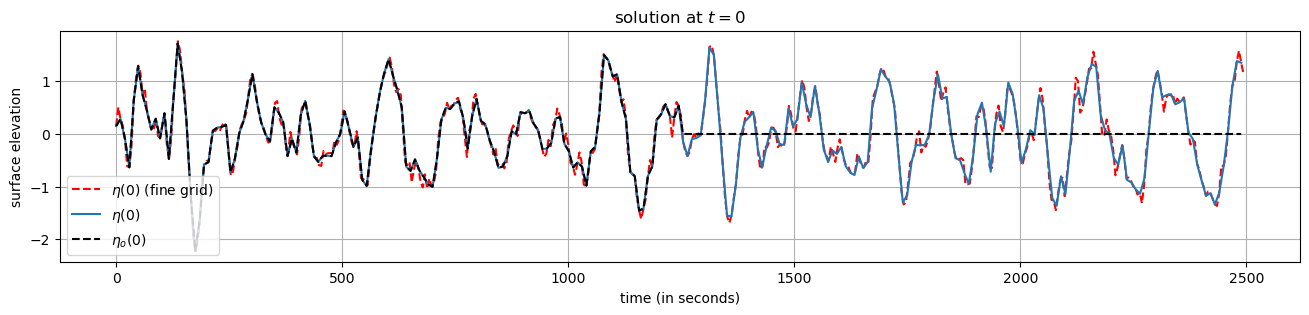

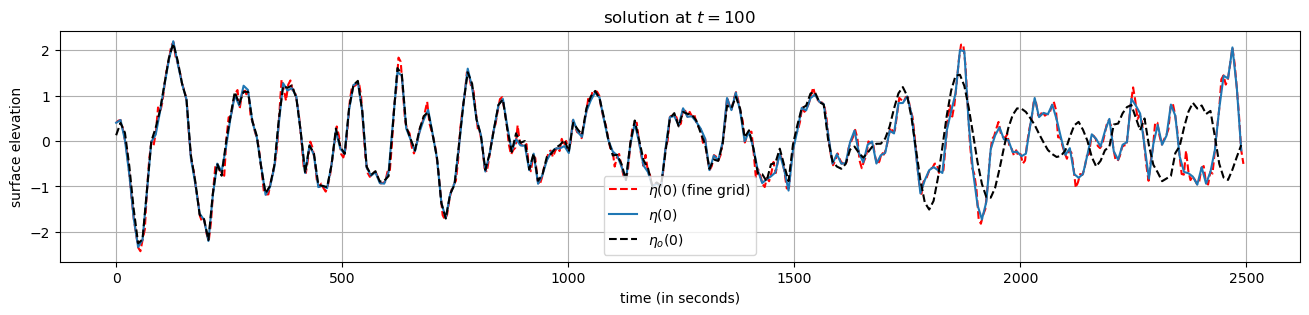

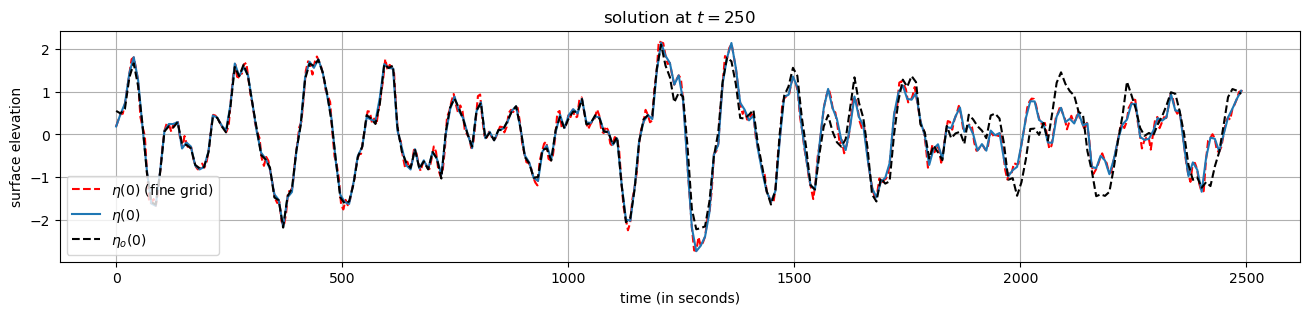

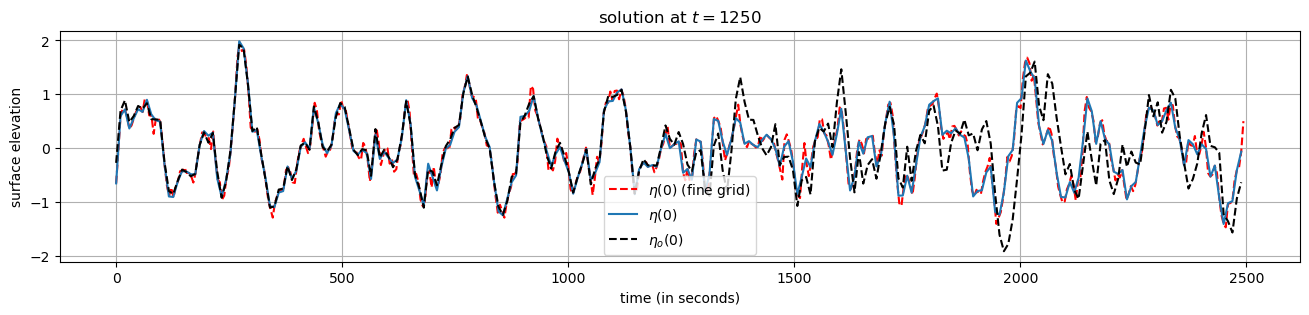

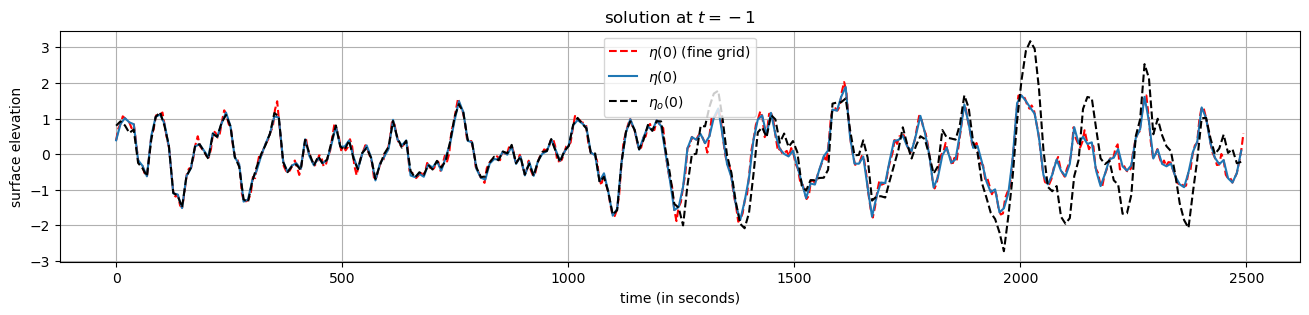

In [391]:
# plot et sauvegarde les snapshots

timeshots_wanted = [0,100,250,1250,-1]

for i,timeshot in enumerate(timeshots_wanted):
    plt.figure(figsize=(16, 3))
    plt.plot(xspace[:Nx//4],eta_func(xspace[:Nx//4],tspace[timeshot]),'r--',label='$\eta(0)$ (fine grid)')
    plt.plot(xspace_obs,eta_func(xspace_obs,tspace[timeshot]),label=f'$\eta(0)$')
    plt.plot(xspace_obs,sol_obs[timeshot,:][Nx_obs:],'k--',label=f'$\eta_o(0)$')
    plt.xlabel('time (in seconds)')
    plt.ylabel('surface elevation')
    plt.legend()
    plt.title(f'solution at $t = {timeshot}$')
    plt.grid()

    plt.savefig(f'results/test_4/t4_snapshot_t{str(timeshot)}')